# Необходимые библиотеки

In [1]:
from collections import defaultdict
import numpy as np
import random
import asyncio
import itertools
import matplotlib.pyplot as plt
from math import sqrt
from scipy.spatial.distance import pdist, squareform, euclidean
from scipy.special import gamma
from itertools import combinations, product
from sklearn.cluster import DBSCAN
import csv
import pandas as pd
from sklearn.metrics import f1_score, mean_squared_error

# Константы

In [2]:
epsilon = 0.05
# data generation 

N = 5
WINDOW_MIN = 8
WINDOW = 15

TRAIN_SIZE = 5000
VAL_SIZE = 200
TEST_SIZE = 200
PTS = 100

train_start = 0
train_end = TRAIN_SIZE

val_init = TRAIN_SIZE + WINDOW - 1
val_start = val_init - 1
val_end = val_start + VAL_SIZE

test_init = val_end + WINDOW - 1
test_start = test_init - 1
test_end = test_start + TEST_SIZE - WINDOW

# clusterize data

WISHART_K = 4
WISHART_H = 0.2

# generate predictions

STEPS, EPS = 50, 0.05
# STEPS, EPS = 60, 0.025

Q_VALUE = 0.99

# Генерация ряда Лоренца

In [3]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        x_0, y_0, z_0 = 1, 1, 1

        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [4]:
xs, _, _ = Lorentz().generate(0.1, 10399)
xs = (xs - xs.min()) / (xs.max() - xs.min())

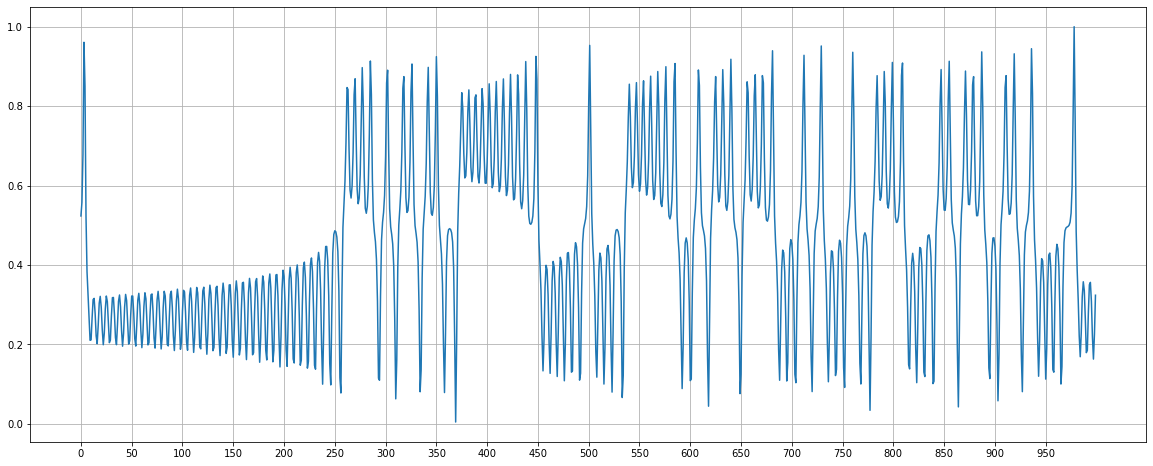

In [5]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [6]:
list_for_delete = []
for i in range(300):
    list_for_delete.append(i)

xs = np.delete(xs, list_for_delete)

xs_train, xs_test = np.split(xs, [10000])
print(len(xs_train), len(xs_test))

10000 100


In [7]:
import csv
with open('xs_test.csv', 'w', newline='') as myfile:
     wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
     wr.writerow(xs_test)

# Функции

In [8]:
def make_prediction(p, q):
    lists_with_list_with_predicted_values = [0] * int(len(p))
    for i in range(len(lists_with_list_with_predicted_values)):
        lists_with_list_with_predicted_values[i] = []

    for i in range(len(p)):
        for j in q:
            if len(j) <= (len(p) - i):
                counter = 0
                counter_for_missed_points = 0
                for k in range(len(j)): 
                    if j[k]:
                        if not p[i + k]:
                            counter_for_missed_points += 1
                        elif abs(p[i + k] - j[k]) <= epsilon:
                            counter += 1
                if (counter >= len(j) - counter_for_missed_points):
                    for k in range(len(j)):
                        lists_with_list_with_predicted_values[i + k].append(j[k])
                        #print(j[k], "добавлено число в элемент", i + k)
    for i in range(len(lists_with_list_with_predicted_values)):
        lists_with_list_with_predicted_values[i] = np.average(lists_with_list_with_predicted_values[i])
    return lists_with_list_with_predicted_values

In [9]:
import itertools

def generate_subsequences(window, num, short=False):
    values = list(range(window))
    result = []
    if short:
        for subseq in itertools.combinations(values, num):
            diff = WINDOW - WINDOW_MIN
            result.append(tuple([num + diff for num in subseq]))
    else:
        for subseq in itertools.combinations(values, num):
            result.append(subseq)
    
    return result

In [10]:
def str_subseq(subseq):
    if not subseq:
        return '<None>'
    return ','.join(map(str, subseq))

def gen_sample_in_point(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None

def gen_sample_in_point_with_q(values, window, pattern, pos):
    # наложить шаблон 
    if pos - window + 1 + pattern[0] >= 0:
        vals = []
        bad = values[pos][0] == None
        for j in pattern:
            val = values[pos - window + 1 + j]
            if val[0] == None:
                bad = True
                break
            vals.append(val)
        if bad:
            return None
        vals.append(values[pos])
        return vals
    else:
        return None
    
def generate_sample(values, window, pattern, put_none=False):
    result = []
    for i in range(len(values)):
        res = gen_sample_in_point(values, window, pattern, i)
        if res == None:
            if put_none:
                result.append(res)
        else:
            result.append(res)
    return result

def aggr(pts):
    if not pts:
        return None
    sum_weight = sum(map(lambda center: center[1], pts))
    pred = sum(map(lambda center: center[0] * center[1], pts))
    return pred / sum_weight

In [11]:
def generate_patterns():
    patterns1 = generate_subsequences(WINDOW_MIN - 1, N - 1, short=True)
    patterns2 = generate_subsequences(WINDOW - 1, N - 1)
    patterns3 = random.choices(patterns2[300:], k=35)
    
    return patterns1 + patterns3

In [12]:
def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    # print(max_diff)
    return max_diff >= h

def partition(dist, l, r, order):
    if l == r:
        return l

    pivot = dist[order[(l + r) // 2]]
    left, right = l - 1, r + 1
    while True:
        while True:
            left += 1
            if dist[order[left]] >= pivot:
                break

        while True:
            right -= 1
            if dist[order[right]] <= pivot:
                break

        if left >= right:
            return right

        order[left], order[right] = order[right], order[left]

def nth_element(dist, order, k):
    l, r = 0, len(order) - 1
    while True:
        if l == r:
            break
        m = partition(dist, l, r, order)
        if m < k:
            l = m + 1
        elif m >= k:
            r = m

def get_clustering(x, k, h, verbose=True):
    n = len(x)
    if isinstance(x[0], list):
        m = len(x[0])
    else:
        m = 1
    dist = squareform(pdist(x))

    dk = []
    for i in range(n):
        order = list(range(n))
        nth_element(dist[i], order, k - 1)
        dk.append(dist[i][order[k - 1]])

    # print(dk)

    p = [k / (volume(dk[i], m) * n) for i in range(n)]

    w = np.full(n, 0)
    completed = {0: False}
    last = 1
    vertices = set()
    for d, i in sorted(zip(dk, range(n))):
        neigh = set()
        neigh_w = set()
        clusters = defaultdict(list)
        for j in vertices:
            if dist[i][j] <= dk[i]:
                neigh.add(j)
                neigh_w.add(w[j])
                clusters[w[j]].append(j)

        vertices.add(i)
        if len(neigh) == 0:
            w[i] = last
            completed[last] = False
            last += 1
        elif len(neigh_w) == 1:
            wj = next(iter(neigh_w))
            if completed[wj]:
                w[i] = 0
            else:
                w[i] = wj
        else:
            if all(completed[wj] for wj in neigh_w):
                w[i] = 0
                continue
            significant_clusters = set(wj for wj in neigh_w if significant(clusters[wj], h, p))
            if len(significant_clusters) > 1:
                w[i] = 0
                for wj in neigh_w:
                    if wj in significant_clusters:
                        completed[wj] = (wj != 0)
                    else:
                        for j in clusters[wj]:
                            w[j] = 0
            else:
                if len(significant_clusters) == 0:
                    s = next(iter(neigh_w))
                else:
                    s = next(iter(significant_clusters))
                w[i] = s
                for wj in neigh_w:
                    for j in clusters[wj]:
                        w[j] = s
    return w

In [13]:
from itertools import groupby

def generate_centers(x_trains, WISHART_K=4, WISHART_H=0.2):
    ws = {}
    for pattern, train in x_trains.items():
        ws[pattern] = get_clustering(train, WISHART_K, WISHART_H)

    centers = {}
    
    for pattern, w in ws.items():
        sorted_by_cluster = sorted(range(len(w)), key=lambda x: w[x])
        for wi, cluster in groupby(sorted_by_cluster, lambda x: w[x]):
            cluster = list(cluster)
            center = np.full(N, 0.0)
            for i in cluster:

                center += x_trains[pattern][i]
            centers.setdefault(pattern, []).append(center / len(cluster))

    return centers

In [14]:
def clusters_create(data_0):
    data = []
    for i in data_0:
        data.append([i, 0])
    clustering = DBSCAN(eps=0.01, min_samples=2).fit(data)
    labels = clustering.labels_
    labels = labels.tolist()
    
    lens = max(labels)
    clusters = []
    for i in range(lens + 2):
        clusters.append([])
        
    for i in range(len(data)):
        clusters[labels[i] + 1].append(data[i])
    
    maxim = 0
    max_len = 0
    for i in range(len(clusters)):
        if len(clusters[i]) > max_len:
            maxim = i
            max_len = len(clusters[i])
    
    return np.average(clusters[maxim])

In [15]:
def make_prediction_with(p, q):
    lists_with_list_with_predicted_values = [0] * int(len(p))
    for i in range(len(lists_with_list_with_predicted_values)):
        lists_with_list_with_predicted_values[i] = []

    for i in range(len(p)):
        for j in q:
            if len(j) <= (len(p) - i):
                counter = 0
                counter_for_missed_points = 0
                for k in range(len(j)): 
                    if j[k]:
                        if not p[i + k]:
                            counter_for_missed_points += 1
                        elif abs(p[i + k] - j[k]) <= epsilon:
                            counter += 1
                if (counter >= len(j) - counter_for_missed_points) and (counter > 1):
                    for k in range(len(j)):
                        lists_with_list_with_predicted_values[i + k].append(j[k])
                        #print(j[k], "добавлено число в элемент", i + k)
    for i in range(len(lists_with_list_with_predicted_values)):
        if len(lists_with_list_with_predicted_values[i]) == 0:
            lists_with_list_with_predicted_values[i] = False
        else:
            lists_with_list_with_predicted_values[i] = clusters_create(lists_with_list_with_predicted_values[i]) * 2
    return lists_with_list_with_predicted_values, lists_with_list_with_predicted_values.count(False)

In [16]:
def create_pat(xs, size_of_pattern, lenght_of_pattern):
    list_of_index = []
    for i in range(len(xs)):
        list_of_index.append(i)

    list_of_tuples_with_index = []
    
    for subseq in itertools.combinations(list_of_index, size_of_pattern):
            list_of_tuples_with_index.append(subseq)
    
    list_with_values = []
    for i in list_of_tuples_with_index:
        current_tuple = [False] * (i[-1] - i[0] + 1)
        for j in i:
            current_tuple[j - i[0]] = xs[j]
        if (len(current_tuple) <= lenght_of_pattern):
            list_with_values.append(current_tuple)
    return list_with_values

# Убираем точки в xs_test

In [17]:
def remove_points(my_list, percentage):
    new_list = [0] * len(my_list)
    todrop = random.sample(range(len(my_list)), len(my_list) - round(len(my_list)*percentage))
    for i in range(len(my_list)):
        if i not in todrop:
            new_list[i] = False
        else:
            new_list[i] = my_list[i]
    return new_list

In [18]:
i = 0
xs_test_real = [0] * len(xs_test)

for x in xs_test:
    xs_test_real[i] = xs_test[i] 
    i += 1

In [19]:
xs_test_5 = remove_points(xs_test_real, 0.05)
xs_test_10 = remove_points(xs_test_real, 0.1)
xs_test_25 = remove_points(xs_test_real, 0.25)
xs_test_50 = remove_points(xs_test_real, 0.5)
xs_test_75 = remove_points(xs_test_real, 0.75)
xs_test_90 = remove_points(xs_test_real, 0.9)

# Создаем массив шаблонов

In [20]:
# ЭТО ВМЕСТО ЧТЕНИЯ ФАЙЛА patterns.csv

# x_trains = {}
# patterns = generate_patterns()

# for pattern in patterns:
#     key = str_subseq(pattern + (WINDOW - 1,))
#    
#    x_trains[key] = generate_sample(xs_train, WINDOW, pattern, put_none=False)

In [21]:
# %%time

# centers = generate_centers(x_trains)

In [22]:
# 

#patterns = []

#for i in centers:
#    current_index = list(map(int, i.split(',')))
#    for j in centers[i]:
#        j = j.tolist()
#        current_tuple = [False] * (current_index[-1] - current_index[0] + 1)
#        
#        p = 0
#        for k in j:
#            current_tuple[current_index[p] - current_index[0]] = k
#            p += 1
#        patterns.append(current_tuple)

In [23]:
with open('patterns.csv', newline='') as f:
    reader = csv.reader(f)
    patterns0 = list(reader)
patterns = []

for x in patterns0:
    y = []
    for obj in x:
        if obj != 'False':
            obj = float(obj)
        else:
            obj = False
        y.append(obj)
    patterns.append(y)

# Предсказание без обработки непрогнозируемых точек

In [24]:
s_xs_test = xs_test
i = 0
res = []

s_predicted = make_prediction(s_xs_test, patterns)

while (mean_squared_error(s_predicted, xs_test_real, squared=False) > 0.001) and (i < 24):
    s_predicted = make_prediction(s_xs_test, patterns)
    s_xs_test = s_predicted
    res.append(mean_squared_error(s_predicted, xs_test_real, squared=False))
    i += 1

print(mean_squared_error(s_predicted, xs_test_real, squared=False), i + 1)

0.020359746267519414 25


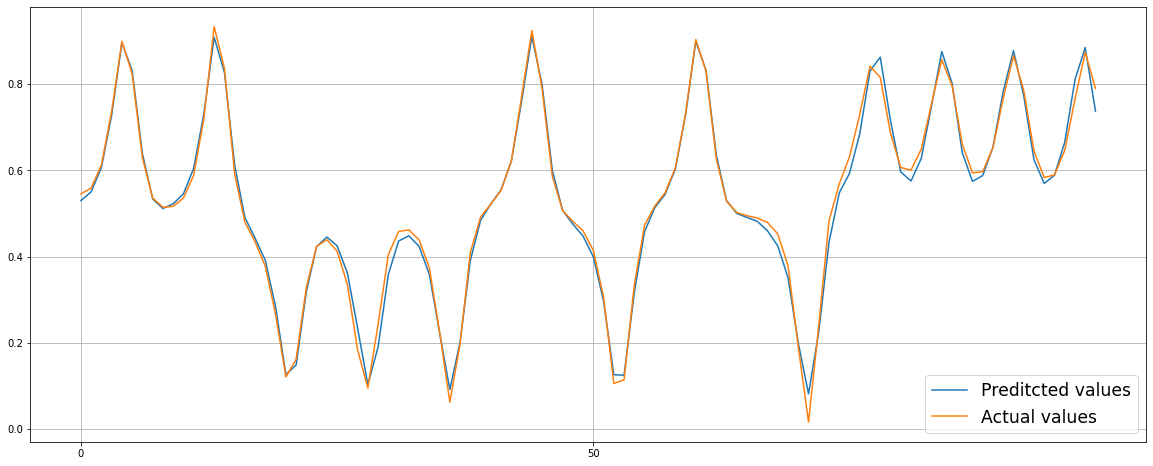

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(s_predicted, label='Predicted values')
plt.plot(xs_test_real, label='Actual values')
plt.xticks([i for i in range(0, 100, 50)])
plt.legend(loc='lower right',fontsize='xx-large')
plt.grid() 
plt.show()

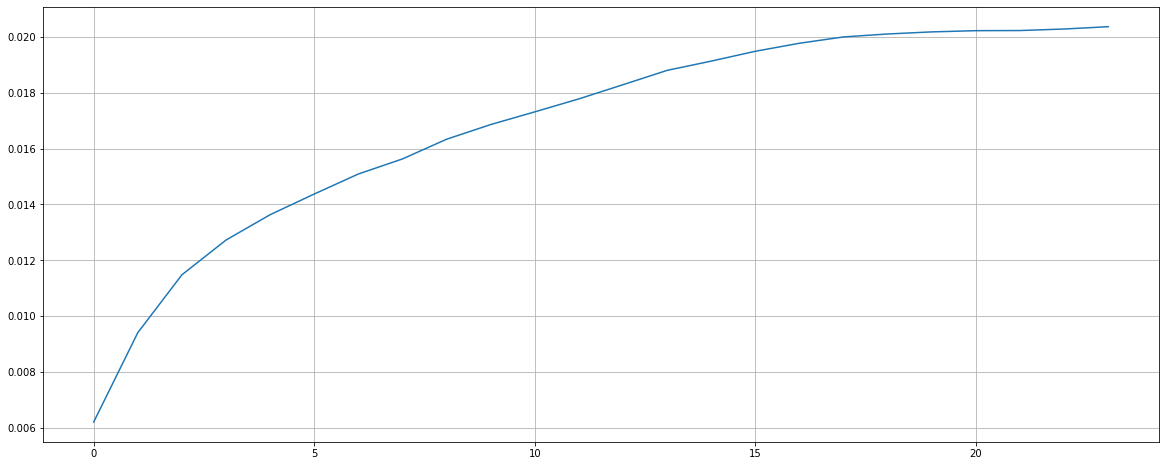

In [26]:
plt.figure(figsize=(20, 8))
plt.plot(res)
plt.grid() 
plt.show()

# Предсказание с обработкой непрогнозируемых точек

# 25

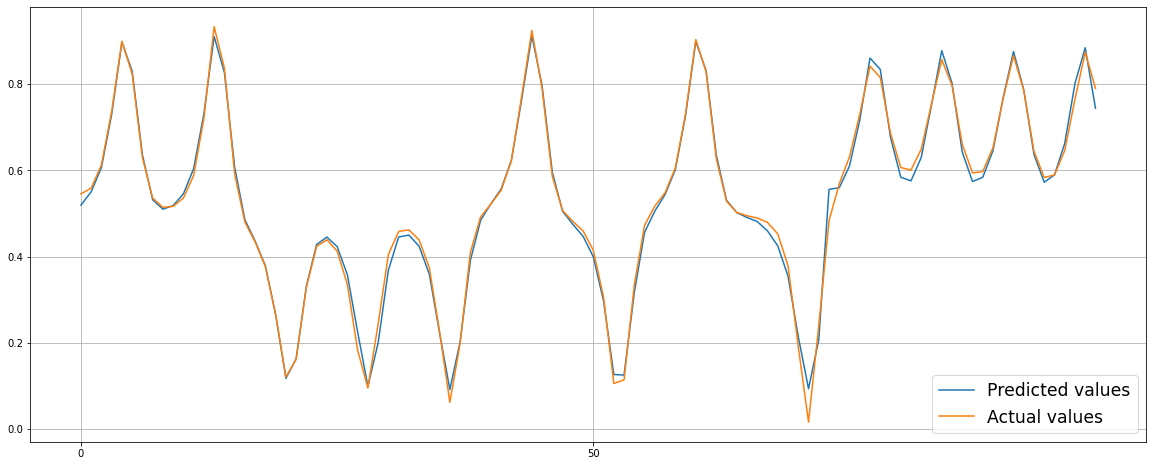

In [27]:
s_xs_test_25 = xs_test_25
i = 0
res = []

s_predicted_25, mist_25 = make_prediction_with(s_xs_test_25, patterns)
res.append(mist_25)

while (mean_squared_error(s_predicted_25, xs_test_real, squared=False) > 0.001) and (i < 9):
    s_predicted_25, mist_25 = make_prediction_with(s_xs_test_25, patterns)
    s_xs_test_25 = s_predicted_25
    res.append(mist_25)
    i += 1


plt.figure(figsize=(20, 8))
plt.plot(s_predicted_25, label='Predicted values')
plt.plot(xs_test_real, label='Actual values')
plt.xticks([i for i in range(0, 100, 50)])
plt.grid()
plt.legend(loc='lower right',fontsize='xx-large')
plt.show()

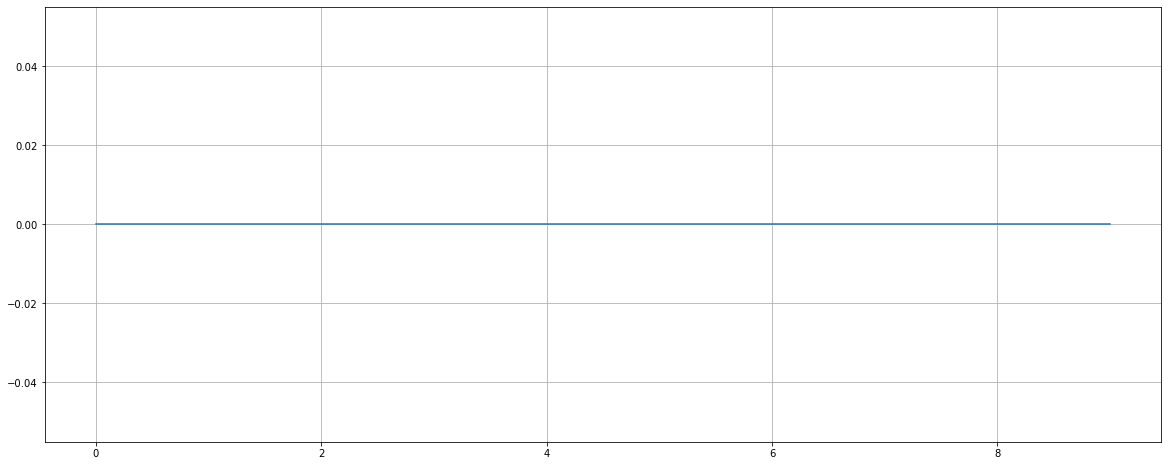

In [28]:
plt.figure(figsize=(20, 8))
plt.plot(res)
plt.grid() 
plt.show()

# 50

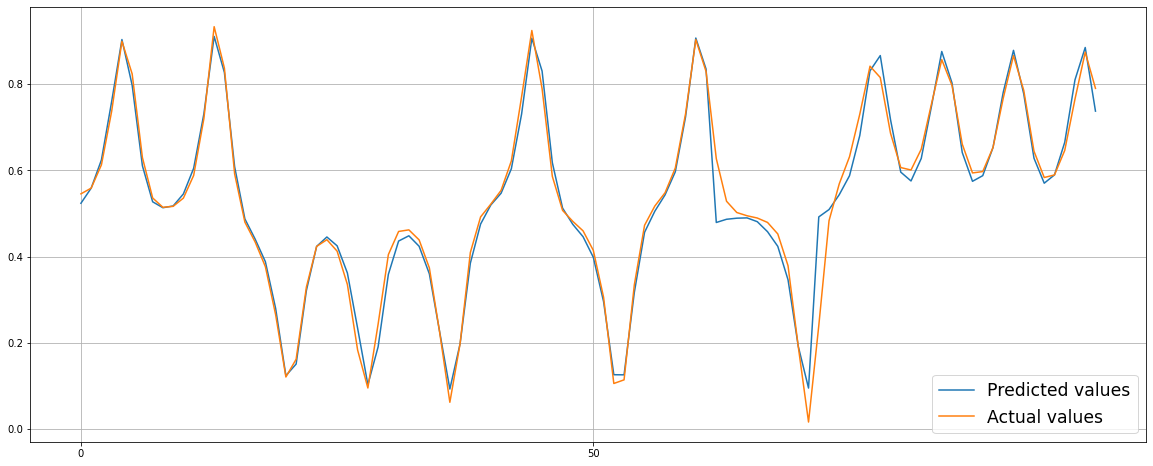

In [29]:
s_xs_test_50 = xs_test_50
i = 0
res = []

s_predicted_50, mist_50 = make_prediction_with(s_xs_test_50, patterns)
res.append(mist_50)

while (mean_squared_error(s_predicted_50, xs_test_real, squared=False) > 0.001) and (i < 19):
    s_predicted_50, mist_50 = make_prediction_with(s_xs_test_50, patterns)
    s_xs_test_50 = s_predicted_50
    res.append(mist_50)
    i += 1

plt.figure(figsize=(20, 8))
plt.plot(s_predicted_50, label='Predicted values')
plt.plot(xs_test_real, label='Actual values')
plt.xticks([i for i in range(0, 100, 50)])
plt.grid()
plt.legend(loc='lower right',fontsize='xx-large')
plt.show()

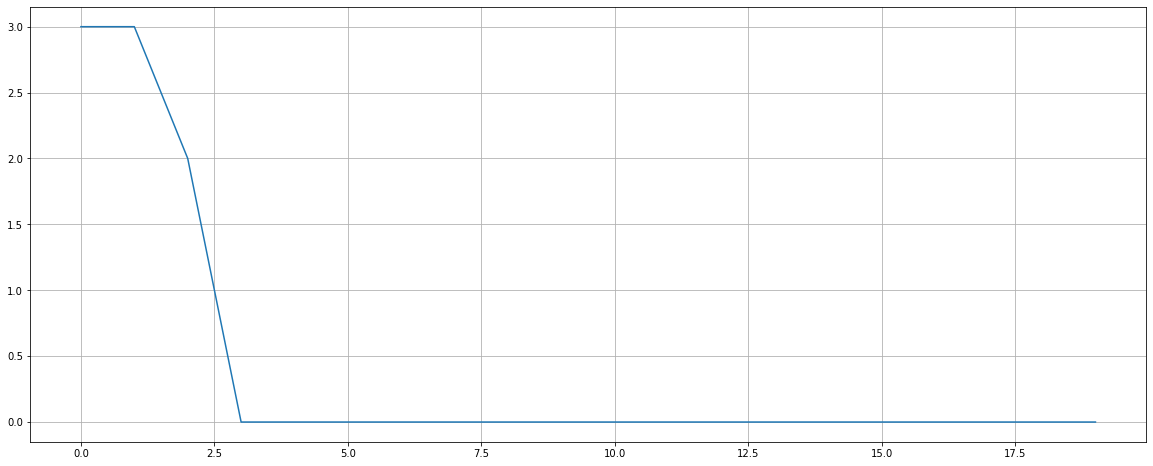

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(res)
plt.grid() 
plt.show()

# 75

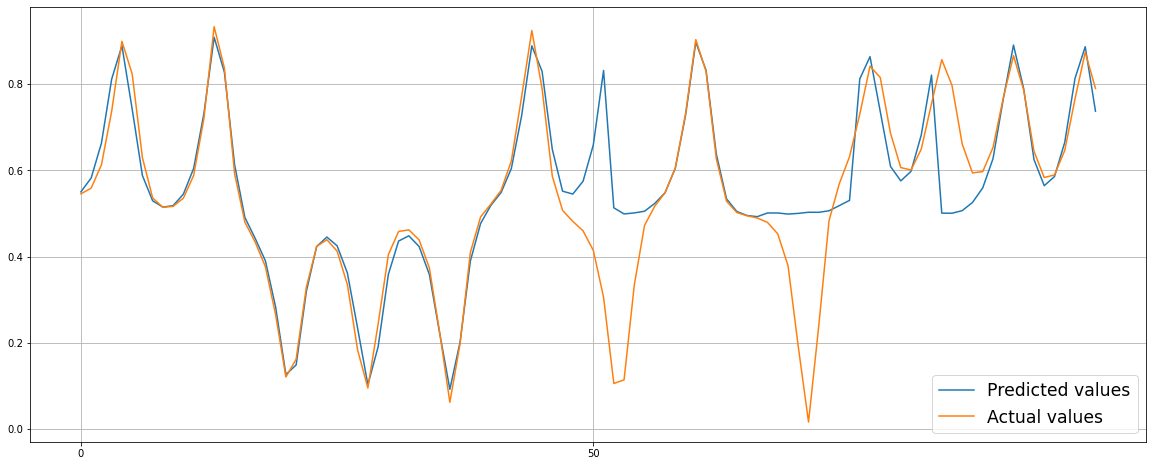

In [31]:
s_xs_test_75 = xs_test_75
i = 0
res = []

s_predicted_75, mist_75 = make_prediction_with(s_xs_test_75, patterns)
res.append(mist_75)

while (mean_squared_error(s_predicted_50, xs_test_real, squared=False) > 0.001) and (i < 19):
    s_predicted_75, mist_75 = make_prediction_with(s_xs_test_75, patterns)
    s_xs_test_75 = s_predicted_75
    res.append(mist_75)
    i += 1

plt.figure(figsize=(20, 8))
plt.plot(s_predicted_75,label='Predicted values')
plt.plot(xs_test_real,label='Actual values')
plt.xticks([i for i in range(0, 100, 50)])
plt.grid() 
plt.legend(loc='lower right',fontsize='xx-large')
plt.show()

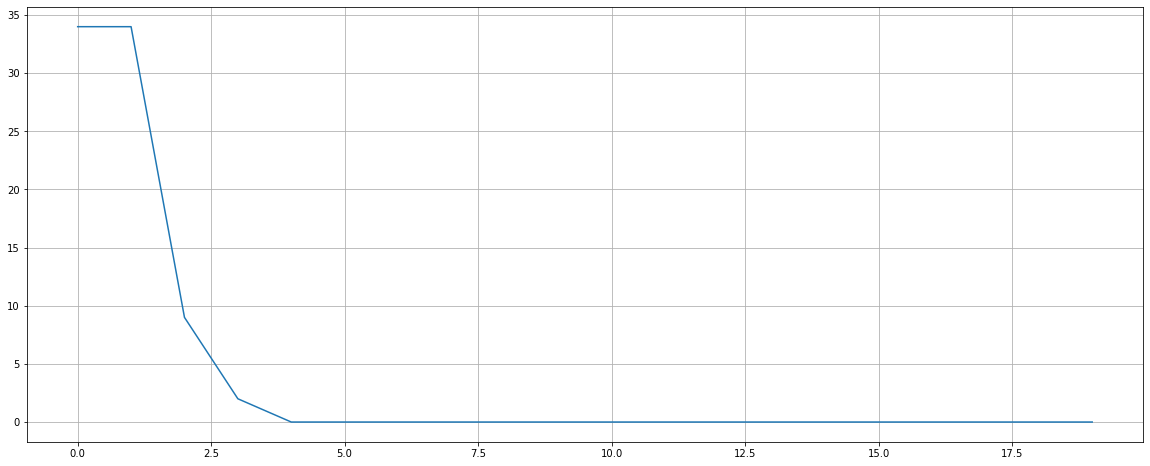

In [32]:
plt.figure(figsize=(20, 8))
plt.plot(res)
plt.grid() 
plt.show()

# 90

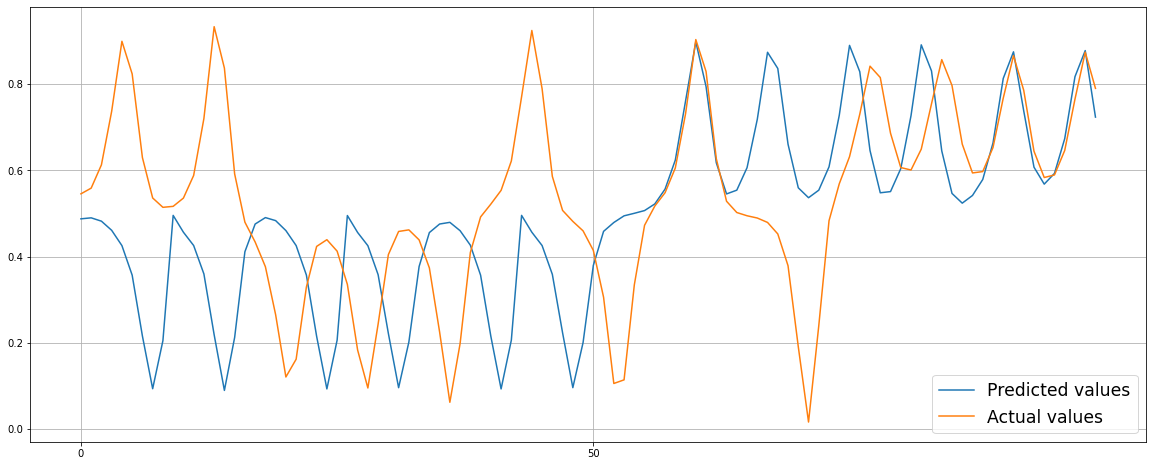

In [35]:
s_xs_test_90 = xs_test_90
i = 0
res = []

s_predicted_90, mist_90 = make_prediction_with(s_xs_test_90, patterns)
res.append(mist_90)

while (mean_squared_error(s_predicted_90, xs_test_real, squared=False) > 0.001) and (i < 30):
    s_predicted_90, mist_90 = make_prediction_with(s_xs_test_90, patterns)
    s_xs_test_90 = s_predicted_90
    res.append(mist_90)
    i += 1

plt.figure(figsize=(20, 8))
plt.plot(s_predicted_90, label='Predicted values')
plt.plot(xs_test_real, label='Actual values')
plt.xticks([i for i in range(0, 100, 50)])
plt.grid() 
plt.legend(loc='lower right',fontsize='xx-large')
plt.show()

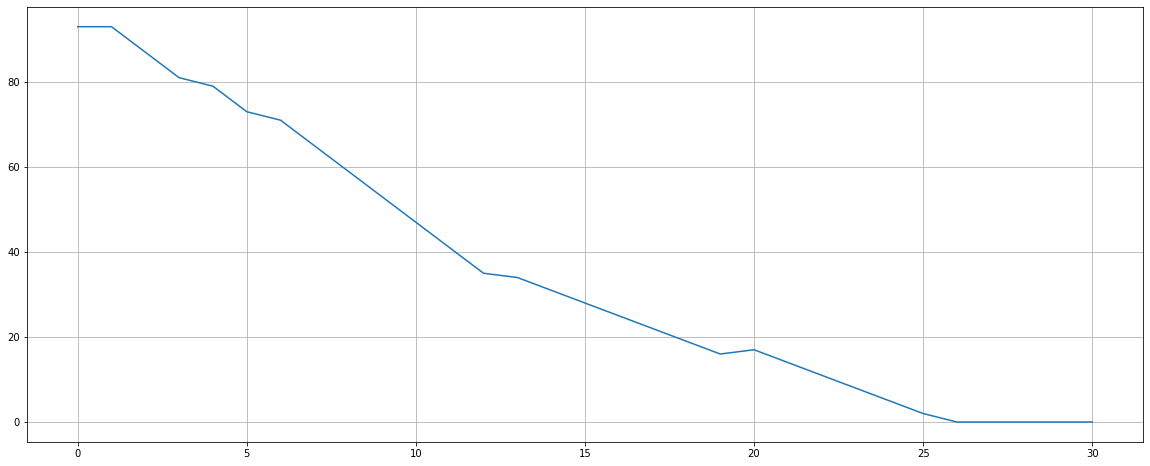

In [36]:
plt.figure(figsize=(20, 8))
plt.plot(res)
plt.grid() 
plt.show()

In [37]:
print(mean_squared_error(s_predicted_25, xs_test_real, squared=False), "25")
print(mean_squared_error(s_predicted_50, xs_test_real, squared=False), "50")
print(mean_squared_error(s_predicted_75, xs_test_real, squared=False), "75")
print(mean_squared_error(s_predicted_90, xs_test_real, squared=False), "90")

0.018842986065936387 25
0.03697334212219668 50
0.1203076351954189 75
0.25768968301960454 90
